In [ ]:
# Install necessary libraries if not already present in Colab environment
!pip install tensorflow scikit-learn matplotlib seaborn pandas numpy

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Scikit-learn for data preprocessing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")

TensorFlow Version: 2.18.0
Keras Version: 3.8.0


### Part 1: Data Preparation for ANN

We'll use the famous Iris dataset for a multi-class classification task. This dataset is small but excellent for demonstrating the basics of ANN classification. We'll perform standard preprocessing steps: feature scaling and one-hot encoding for the target variable.

**Tasks:**
* Load the Iris dataset.
* Separate features (X) and target (y).
* Encode the categorical target variable using `LabelEncoder` and then `to_categorical` (one-hot encoding).
* Split the data into training and testing sets.
* Scale the numerical features using `StandardScaler`.

In [ ]:
# Load the Iris dataset from scikit-learn
from sklearn.datasets import load_iris
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target)
target_names = iris.target_names

print(f"Original dataset shape: {X.shape}, Target shape: {y.shape}")
print("\nFirst 5 rows of features (X):")
print(X.head())
print("\nFirst 5 rows of target (y):")
print(y.head())
print(f"Target classes: {target_names}")

Original dataset shape: (150, 4), Target shape: (150,)

First 5 rows of features (X):
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

First 5 rows of target (y):
0    0
1    0
2    0
3    0
4    0
dtype: int64
Target classes: ['setosa' 'versicolor' 'virginica']


### 1. Encode the target variable (y)

In [ ]:
# Label Encoding: Convert string labels to numerical (e.g., 'setosa' -> 0)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# One-hot Encoding: Convert numerical labels to binary vectors (e.g., 0 -> [1,0,0])
# This is required for multi-class classification with categorical cross-entropy loss.
num_classes = len(np.unique(y_encoded))
y_one_hot = to_categorical(y_encoded, num_classes=num_classes)

print(f"\nOriginal y (first 5): {y.head().tolist()}")
print(f"Encoded y (first 5): {y_encoded[:5].tolist()}")
print(f"One-hot encoded y (first 5):\n{y_one_hot[:5]}")
print(f"Number of classes: {num_classes}")


Original y (first 5): [0, 0, 0, 0, 0]
Encoded y (first 5): [0, 0, 0, 0, 0]
One-hot encoded y (first 5):
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
Number of classes: 3


### 2. Split data into training and testing sets

In [ ]:
X_train, X_test, y_train_oh, y_test_oh = train_test_split(X, y_one_hot, test_size=0.2, random_state=42, stratify=y_encoded)
# Keep original y_test for non-one-hot evaluation later if needed
_, _, _, y_test_original = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


print(f"\nTraining features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training target (one-hot) shape: {y_train_oh.shape}")
print(f"Testing target (one-hot) shape: {y_test_oh.shape}")


Training features shape: (120, 4)
Testing features shape: (30, 4)
Training target (one-hot) shape: (120, 3)
Testing target (one-hot) shape: (30, 3)


### 3. Scale numerical features
* Scaling is crucial for ANNs as it helps gradient descent converge faster and prevents features with larger values from **dominating** the learning process.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Use transform (not fit_transform) on test set

print("\nFirst 5 rows of scaled X_train:")
print(X_train_scaled[:5])


First 5 rows of scaled X_train:
[[-1.72156775 -0.33210111 -1.34572231 -1.32327558]
 [-1.12449223 -1.22765467  0.41450518  0.6517626 ]
 [ 1.14439475 -0.5559895   0.58484978  0.25675496]
 [-1.12449223  0.11567567 -1.28894078 -1.45494479]
 [-0.40800161 -1.22765467  0.13059752  0.12508575]]


### **Discussion Point:**
* Explain why both Label Encoding and One-Hot Encoding were necessary for the target variable in this multi-class classification problem.
* Why is feature scaling important for training a neural network? How might the absence of scaling affect the training process and model performance?

### Part 2: Building and Training a Simple Feedforward ANN (MLP)

We will now build a basic Multilayer Perceptron (MLP) using Keras, train it on our preprocessed Iris dataset, and observe its performance.

**Tasks:**
* Define the ANN model architecture (input layer, hidden layers, output layer) using `keras.Sequential`.
* Compile the model with an appropriate loss function, optimizer, and metrics.
* Train the model using the `fit` method.
* Visualize the training history (loss and accuracy over epochs).

In [ ]:
# Define the model architecture
# We'll create a simple MLP with one hidden layer.
model = keras.Sequential([
    # Input Layer: Corresponds to the number of features in X_train_scaled
    keras.Input(shape=(X_train_scaled.shape[1],), name='input_layer'),

    # Hidden Layer 1: A dense (fully connected) layer with ReLU activation
    # ReLU is a common choice for hidden layers due to its computational efficiency
    # and ability to mitigate vanishing gradients.
    layers.Dense(units=10, activation='relu', name='hidden_layer_1'), # 10 neurons in the hidden layer

    # Output Layer:
    # Number of units = num_classes (3 for Iris)
    # Softmax activation: For multi-class classification, outputs probabilities that sum to 1.
    layers.Dense(units=num_classes, activation='softmax', name='output_layer')
])

# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 10)             │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83 (332.00 B)

 Trainable params: 83 (332.00 B)

 Non-trainable params: 0 (0.00 B)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


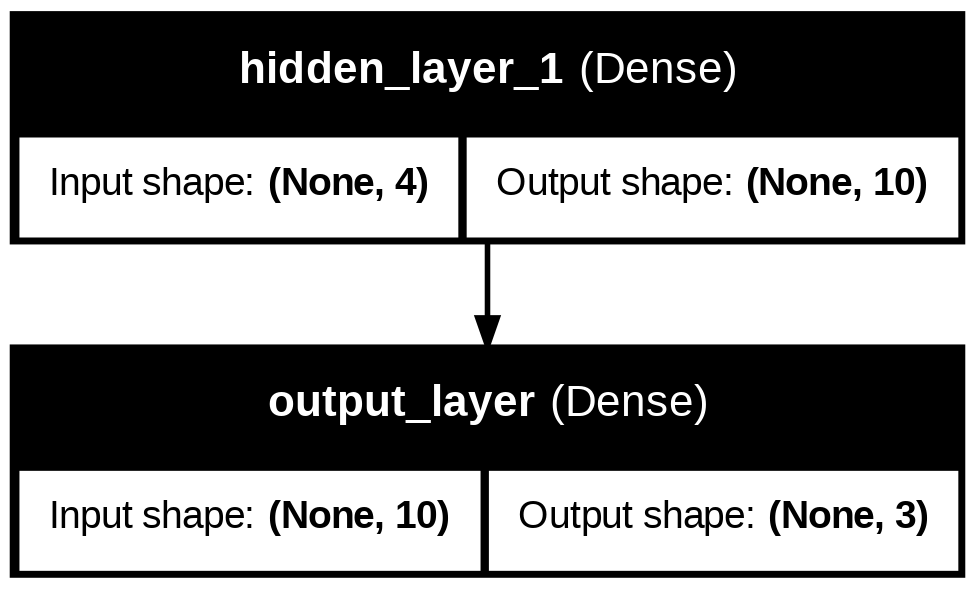

In [ ]:
# Visualize the model architecture
# Install graphviz if needed
!pip install graphviz
!apt-get install graphviz

tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)


Starting model training...
Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4286 - loss: 1.2129 - val_accuracy: 0.1667 - val_loss: 1.3825
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4289 - loss: 1.1320 - val_accuracy: 0.1667 - val_loss: 1.2994
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3839 - loss: 1.0725 - val_accuracy: 0.1667 - val_loss: 1.2259
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4727 - loss: 1.0241 - val_accuracy: 0.1667 - val_loss: 1.1575
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4596 - loss: 0.9863 - val_accuracy: 0.1667 - val_loss: 1.0955
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4351 - loss: 0.9783 - val_accuracy: 0.1667 - val_loss: 1.0339
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5875 - loss: 0.8820 - val_accuracy: 0.5833 - val_loss: 0.9838
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6318 - loss: 0.8646 - val

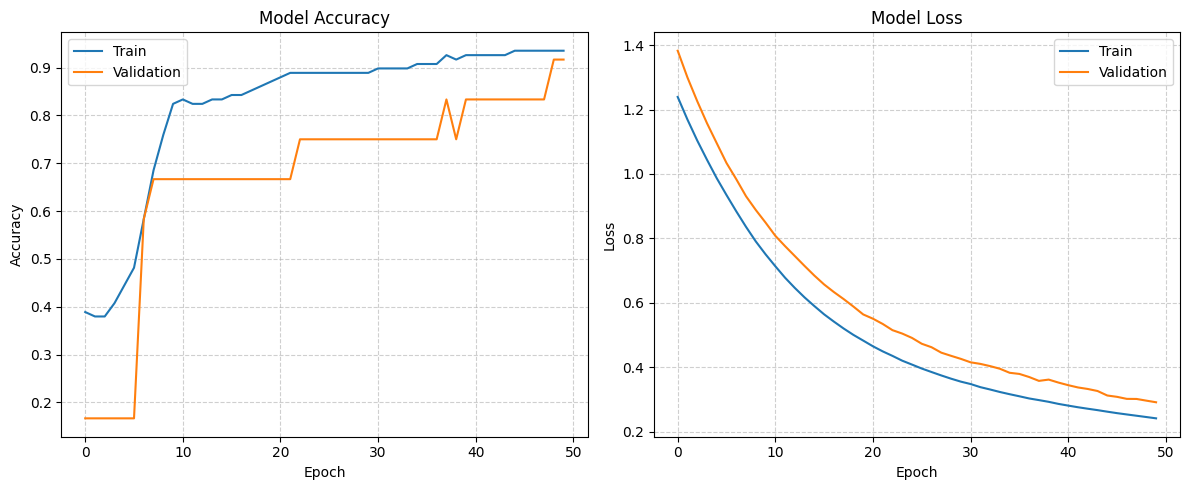

In [ ]:
# Compile the model
# Optimizer: 'adam' is a popular choice for its efficiency and good performance in many scenarios.
# Loss Function: 'categorical_crossentropy' is used for multi-class classification with one-hot encoded labels.
# Metrics: 'accuracy' to monitor classification performance during training.
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
# epochs: Number of complete passes through the training dataset.
# batch_size: Number of samples per gradient update.
# validation_split: Reserve a portion of training data for validation during training.
print("\nStarting model training...")
history = model.fit(X_train_scaled, y_train_oh,
                    epochs=50,          # You can adjust the number of epochs
                    batch_size=8,       # You can adjust the batch size
                    validation_split=0.1, # Use 10% of training data for validation
                    verbose=1)          # Display training progress

print("\nTraining complete.")

# Visualize training history (loss and accuracy)
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

### **Discussion Points:**
* Describe the architecture of the ANN you built (number of layers, neurons per layer, activation functions).
* What is the purpose of the `compile` step in Keras? Explain the role of the `optimizer` and `loss` function.
* Analyze the training history plots. Does the model appear to be learning effectively? Is there any sign of overfitting or underfitting?


### Part 3: Model Evaluation and Prediction

After training, it's crucial to evaluate the model's performance on unseen data (the test set) to ensure it generalizes well.

**Tasks:**
* Make predictions on the test set.
* Convert probabilistic predictions back to class labels.
* Evaluate the model using `accuracy_score`, `precision_score`, `recall_score`, `f1_score`, and `classification_report`.
* Plot a confusion matrix.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

Shape of predicted probabilities: (30, 3)
First 5 predicted probabilities:
[[0.9673828  0.0260301  0.00658699]
 [0.01299555 0.22098392 0.76602054]
 [0.22556487 0.71684253 0.05759247]
 [0.11088667 0.84604895 0.04306443]
 [0.9775967  0.01553797 0.0068653 ]]

First 5 predicted labels: [0, 2, 1, 1, 0]
First 5 true labels (original encoded): [0, 2, 1, 1, 0]

--- Model Evaluation (on Test Set) ---
Accuracy: 0.8667
Precision (macro): 0.8750
Recall (macro): 0.8667
F1-Score (macro): 0.8653

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.88      0.70      0.78        10
   virginica       0.75      0.90      0.82        10

    accuracy                           0.87        30
   macro avg       0.88      0.87      0.87        30
weighted avg       0.88      0.87      0.87        30



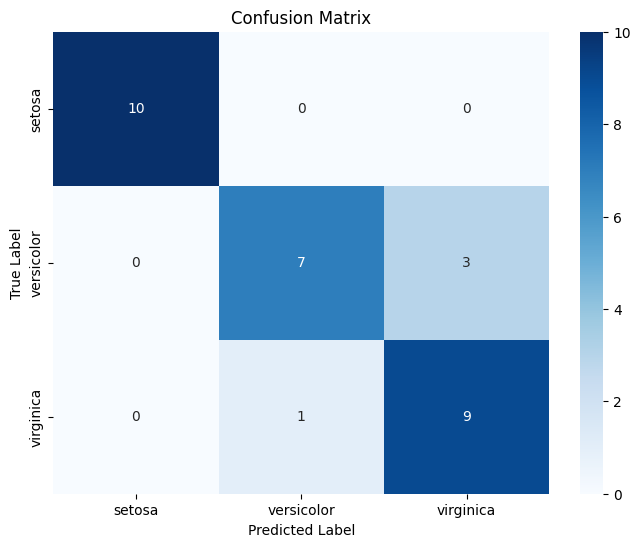

In [ ]:
# Make predictions on the test set
# predict returns probabilities for each class
y_pred_proba = model.predict(X_test_scaled)
print(f"\nShape of predicted probabilities: {y_pred_proba.shape}")
print(f"First 5 predicted probabilities:\n{y_pred_proba[:5]}")

# Convert probabilities to class labels (index of the highest probability)
y_pred_labels = np.argmax(y_pred_proba, axis=1)
print(f"\nFirst 5 predicted labels: {y_pred_labels[:5].tolist()}")
print(f"First 5 true labels (original encoded): {y_test_original[:5].tolist()}")

# Evaluate the model
print(f"\n--- Model Evaluation (on Test Set) ---")
print(f"Accuracy: {accuracy_score(y_test_original, y_pred_labels):.4f}")
print(f"Precision (macro): {precision_score(y_test_original, y_pred_labels, average='macro'):.4f}")
print(f"Recall (macro): {recall_score(y_test_original, y_pred_labels, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_test_original, y_pred_labels, average='macro'):.4f}")

# Classification Report provides detailed per-class metrics
print("\nClassification Report:")
print(classification_report(y_test_original, y_pred_labels, target_names=target_names))

# Plot Confusion Matrix
cm = confusion_matrix(y_test_original, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### **Discussion Points:**
* What do the precision, recall, and F1-score metrics tell you about the model's performance compared to simple accuracy?
* Analyze the confusion matrix. Which classes (if any) are the model struggling to differentiate? What does a perfect confusion matrix look like?

### Part 4: Hyperparameter Tuning and Overfitting/Regularization

Neural network performance is highly dependent on hyperparameters (e.g., number of layers, neurons, activation functions, learning rate, epochs, batch size). Overfitting is a common problem where the model learns the training data too well, failing to generalize to new data. Regularization techniques can help mitigate this.

**Tasks:**
* **Experiment with different architectures:**
    * Add more hidden layers.
    * Change the number of neurons in hidden layers.
    * Try different activation functions (e.g., `tanh`, `sigmoid` for hidden layers, though `relu` is generally preferred for deeper networks).
* **Implement Early Stopping:** Monitor validation loss and stop training when it no longer improves.
* (Optional) **Implement Dropout:** Add `layers.Dropout` layers to introduce regularization.

### Experiment 1: Deeper Network with More Neurons

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1_deep (Dense)     │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2_deep (Dense)     │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,499 (9.76 KB)

 Trainable params: 2,499 (9.76 KB)

 Non-trainable params: 0 (0.00 B)


Starting training for Deeper Network with Early Stopping...
Deeper network training stopped at epoch 83 (best epoch was restored).
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Deeper Model Accuracy: 0.9333
Deeper Model Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



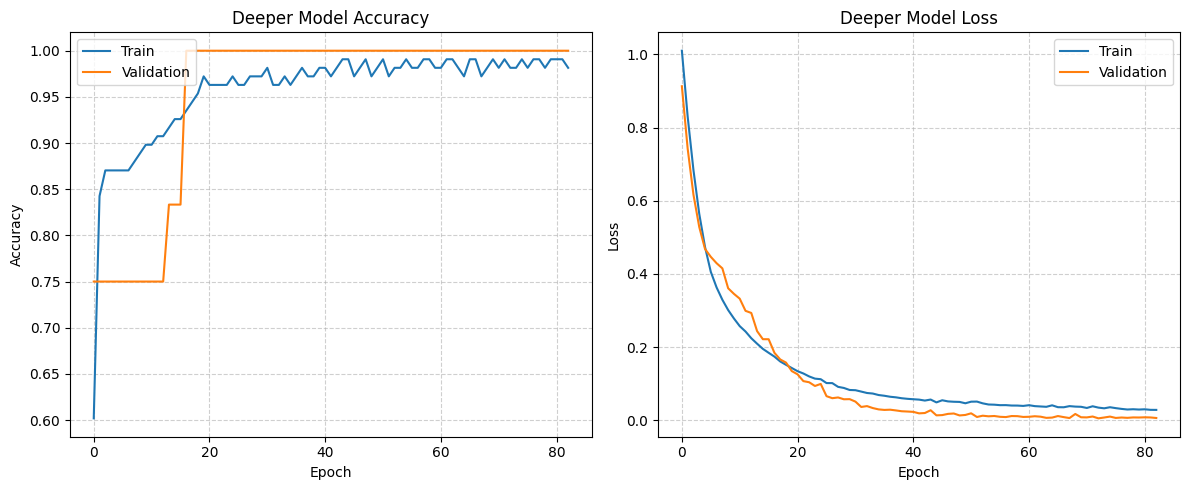

In [ ]:
model_deep = keras.Sequential([
    keras.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(units=64, activation='relu', name='hidden_layer_1_deep'), # More neurons
    layers.Dense(units=32, activation='relu', name='hidden_layer_2_deep'), # Second hidden layer
    layers.Dense(units=num_classes, activation='softmax')
])
model_deep.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_deep.summary()

# Use Early Stopping to prevent overfitting
# Monitors 'val_loss' and stops if it doesn't improve for 'patience' epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("\nStarting training for Deeper Network with Early Stopping...")
history_deep = model_deep.fit(X_train_scaled, y_train_oh,
                              epochs=100, # Set a higher max epoch, EarlyStopping will manage it
                              batch_size=8,
                              validation_split=0.1,
                              callbacks=[early_stopping], # Add the EarlyStopping callback
                              verbose=0) # Set to 0 to suppress per-epoch output for brevity

print(f"Deeper network training stopped at epoch {len(history_deep.history['loss'])} (best epoch was restored).")

# Evaluate the deeper model
y_pred_deep = np.argmax(model_deep.predict(X_test_scaled), axis=1)
print(f"Deeper Model Accuracy: {accuracy_score(y_test_original, y_pred_deep):.4f}")
print("Deeper Model Classification Report:\n", classification_report(y_test_original, y_pred_deep, target_names=target_names))

# Plot training history for the deeper model
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_deep.history['accuracy'])
plt.plot(history_deep.history['val_accuracy'])
plt.title('Deeper Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(history_deep.history['loss'])
plt.plot(history_deep.history['val_loss'])
plt.title('Deeper Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Experiment 2: Network with Dropout for Regularization

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1_dropout (Dense)  │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2_dropout (Dense)  │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,499 (9.76 KB)

 Trainable params: 2,499 (9.76 KB)

 Non-trainable params: 0 (0.00 B)


Starting training for Dropout Network with Early Stopping...
Dropout network training stopped at epoch 86 (best epoch was restored).
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Dropout Model Accuracy: 0.9333
Dropout Model Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



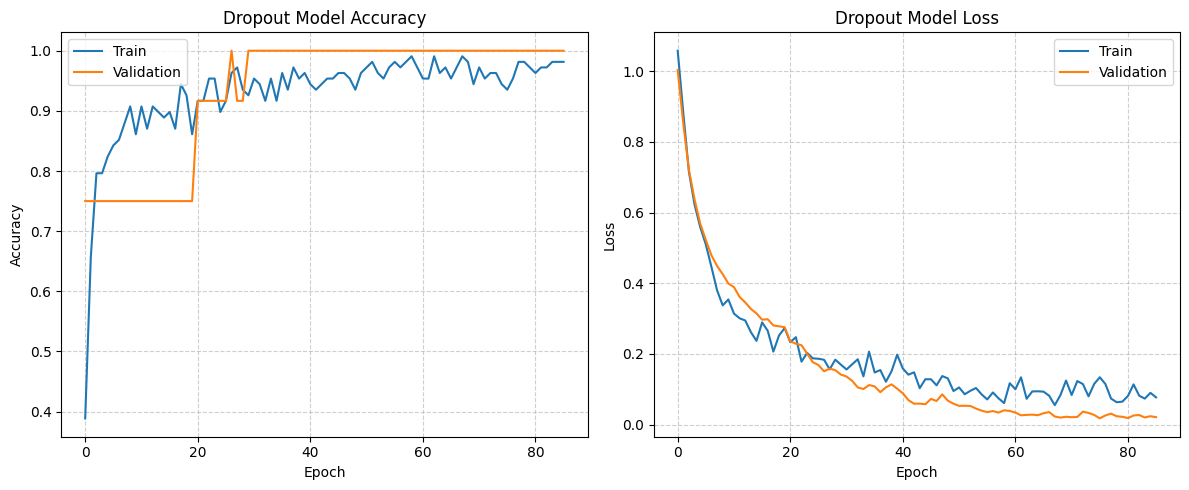

In [ ]:
model_dropout = keras.Sequential([
    keras.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(units=64, activation='relu', name='hidden_layer_1_dropout'),
    layers.Dropout(0.3), # Dropout layer: randomly sets a fraction of input units to 0 at each update during training
    layers.Dense(units=32, activation='relu', name='hidden_layer_2_dropout'),
    layers.Dropout(0.3),
    layers.Dense(units=num_classes, activation='softmax')
])
model_dropout.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_dropout.summary()

print("\nStarting training for Dropout Network with Early Stopping...")
history_dropout = model_dropout.fit(X_train_scaled, y_train_oh,
                                    epochs=100,
                                    batch_size=8,
                                    validation_split=0.1,
                                    callbacks=[early_stopping], # Re-use the early stopping callback
                                    verbose=0)

print(f"Dropout network training stopped at epoch {len(history_dropout.history['loss'])} (best epoch was restored).")

# Evaluate the dropout model
y_pred_dropout = np.argmax(model_dropout.predict(X_test_scaled), axis=1)
print(f"Dropout Model Accuracy: {accuracy_score(y_test_original, y_pred_dropout):.4f}")
print("Dropout Model Classification Report:\n", classification_report(y_test_original, y_pred_dropout, target_names=target_names))

# Plot training history for the dropout model
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dropout.history['accuracy'])
plt.plot(history_dropout.history['val_accuracy'])
plt.title('Dropout Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(history_dropout.history['loss'])
plt.plot(history_dropout.history['val_loss'])
plt.title('Dropout Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### **Discussion Points:**
* Compare the performance of the simple model from Part 2 with the deeper/regularized models from Part 4. Did the changes in architecture or regularization help? Why or why not?
* Explain the concept of "overfitting" in neural networks. How does Early Stopping help to prevent it?
* How does Dropout work as a regularization technique, and what is its intuition?


### Part 5: Advanced Topics & Discussion

This section is for broader discussion and conceptual understanding, extending beyond direct coding.

**Discussion Topics:**
* **Activation Functions:** Beyond ReLU, Sigmoid, and Softmax, discuss other common activation functions (e.g., Leaky ReLU, ELU, Swish) and their typical use cases.
* **Optimizers:** Briefly explain how optimizers like Adam, RMSprop, and SGD differ from basic Gradient Descent and why they are often preferred.
* **Loss Functions:** Discuss how the choice of loss function is tied to the type of problem (e.g., Binary Cross-Entropy vs. Categorical Cross-Entropy, MSE).
* **Common Challenges:** What are some common challenges encountered when training neural networks (e.g., vanishing/exploding gradients, local minima, computational cost), and how are they addressed?
* **Beyond MLPs:** Briefly introduce (conceptually) when you would use CNNs vs. RNNs vs. Transformers compared to a simple MLP.
---


### **1. Activation Functions:**

- **ReLU (Rectified Linear Unit):** $f(x) = max(0, x)$
  - *Pros:* Computationally efficient, helps mitigate vanishing gradient problem, introduces non-linearity.  
  - *Cons:* Dying ReLU problem (neurons can become inactive).  
  - *Use Case:* Most common activation for hidden layers in deep networks.

- **Sigmoid:**  $f(x) = 1 / (1 + e^{-x})$
  - *Pros:* Outputs probabilities between 0 and 1, useful for binary classification output layer.  
  - *Cons:* Suffers from vanishing gradients (especially for very large/small inputs), outputs are not zero-centered.  
  - *Use Case:* Output layer for binary classification.

- **Tanh (Hyperbolic Tangent):**  $f(x) = (e^x - e^{-x}) / (e^x + e^{-x})$
  - *Pros:* Outputs between -1 and 1 (zero-centered), which often helps optimization.  
  - *Cons:* Still suffers from vanishing gradients for extreme values.  
  - *Use Case:* Hidden layers (historically), sometimes output layer for values between -1 and 1.

- **Softmax:**  $f(x_i) = e^{x_i} / \sum_j e^{x_j}$
  - *Pros:* Outputs probabilities for multiple classes that sum to 1.  
  - *Cons:* Only suitable for output layer in multi-class classification.  
  - *Use Case:* Output layer for multi-class classification.

- **Leaky ReLU:**  $f(x) = \begin{cases} x & \text{if } x > 0 \\ \alpha x & \text{otherwise} \end{cases}$  
  - *Pros:* Addresses dying ReLU by allowing a small gradient for negative inputs.  
  - *Cons:* Still not always guaranteed to prevent dying neurons.

- **ELU (Exponential Linear Unit):**  $ f(x) = \begin{cases} x & \text{if } x > 0 \\ \alpha (e^x - 1) & \text{otherwise} \end{cases} $
  - *Pros:* Addresses dying ReLU, produces negative outputs which push mean activations closer to zero (less bias shift).

- **Swish:**  $f(x) = x \cdot \text{sigmoid}(x)$
  - *Pros:* Self-gated, performs better than ReLU on deeper models, smoother than ReLU.


### **2. Optimizers:**

- **Gradient Descent (Vanilla GD):**  
  Updates weights based on the gradient of the loss function calculated over the *entire* training dataset. Slow for large datasets.

- **Stochastic Gradient Descent (SGD):**  
  Updates weights based on the gradient from *one* randomly chosen training example at a time. Faster, but updates are noisy.

- **Mini-Batch Gradient Descent:**  
  Updates weights using a small batch of examples. Balances speed and stability.

- **Adam (Adaptive Moment Estimation):**  
  - *How it differs:* Uses both first (mean) and second (variance) moment estimates of gradients.  
  - *Why preferred:* Combines AdaGrad and RMSprop; performs well out-of-the-box.

- **RMSprop (Root Mean Square Propagation):**  
  - *How it differs:* Uses exponentially decaying average of squared gradients.  
  - *Why preferred:* Good for RNNs and non-stationary objectives.

- **Adagrad (Adaptive Gradient Algorithm):**  
  - *How it differs:* Adapts learning rate per parameter, with larger updates for infrequent parameters.  
  - *Why preferred:* Effective on sparse data.



### **3. Loss Functions:**

- **Categorical Cross-Entropy:**  
  - *Use Case:* Multi-class classification with one-hot encoded labels.

- **Sparse Categorical Cross-Entropy:**  
  - *Use Case:* Multi-class classification with integer-encoded labels.

- **Binary Cross-Entropy:**  
  - *Use Case:* Binary classification (0 or 1 target labels). Often used with Sigmoid.

- **Mean Squared Error (MSE):**  
  - *Use Case:* Regression; measures the square of prediction errors.

- **Mean Absolute Error (MAE):**  
  - *Use Case:* Regression; measures average absolute errors. More robust to outliers than MSE.



### **4. Common Challenges when Training Neural Networks and Solutions:**

- **Vanishing/Exploding Gradients:**  
  - *Solutions:* He/Xavier initialization, ReLU-family activations, Batch Norm, Gradient Clipping.

- **Overfitting:**  
  - *Solutions:* More data, Data Augmentation, Regularization (L1/L2, Dropout), Early Stopping, simpler model.

- **Underfitting:**  
  - *Solutions:* More complex models, longer training, better features.

- **Computational Cost:**  
  - *Solutions:* Use GPUs/TPUs, efficient optimizers, smaller batch sizes, model pruning.

- **Local Minima (and Plateaus):**  
  - *Solutions:* Better optimizers (Adam, RMSprop), momentum, good initialization.

- **Data Requirements:**  
  - *Solutions:* Data Augmentation, Transfer Learning (pre-trained models).



### **5. Beyond MLPs (When to use other architectures):**

- **Convolutional Neural Networks (CNNs):**  
  - *When to use:* Image, video, or spatial data.  
  - *Why:* Learn local patterns (edges, textures); pooling provides translation invariance.

- **Recurrent Neural Networks (RNNs, LSTMs, GRUs):**  
  - *When to use:* Sequential data (e.g., time series, language, speech).  
  - *Why:* Maintain memory of past inputs; handle variable-length sequences.

- **Transformer Networks:**  
  - *When to use:* NLP (and increasingly vision tasks).  
  - *Why:* Self-attention captures long-range dependencies, enables parallel processing.

---
  
<center>

<span style="color:#1f4e79">

Prepared By

**<span style="font-size:1.5em">Md. Atikuzzaman</span>**  
Lecturer  
Department of Computer Science and Engineering  
Green University of Bangladesh  
Email: atik@cse.green.edu.bd  

</span>
</center>

---
